In [67]:
import re
import string
from nltk.corpus import stopwords
import nltk
import pandas as pd
from collections import Counter
from nltk import ngrams
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [68]:
# to remove articles, prepositions, and conjunctions
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\monto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [69]:
# load the dataset
df = pd.read_csv('train.csv')

# Limpieza de datos

In [70]:
def preprocess_text(text):
    #convert text to lowercase
    text = text.lower()
    
    #removing urls
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    #removing mentions and hashtags, mentions are removed because they are not important, 
    # only removing the '#' symbol from hashtags because the text in the hashtag might be important
    text = re.sub(r'\@\w+|\#', '', text)
    
    #removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    #removing numbers except 911, 911 is kept because it is an emergency so it is important
    text = re.sub(r'\b(?!911\b)\d+\b', '', text)
    
    #removing stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

In [71]:
# apply the function to the text column
df['clean_text'] = df['text'].apply(preprocess_text)

In [72]:
df[['text', 'clean_text']].head()

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders cal...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...


In [73]:
disaster_tweets = df[df['target'] == 1]['clean_text']
non_disaster_tweets = df[df['target'] == 0]['clean_text']

In [74]:
disaster_words = ' '.join(disaster_tweets).split()
non_disaster_words = ' '.join(non_disaster_tweets).split()

In [75]:
disaster_word_freq = Counter(disaster_words)
non_disaster_word_freq = Counter(non_disaster_words)

Text(0.5, 1.0, 'Most common words in disaster tweets')

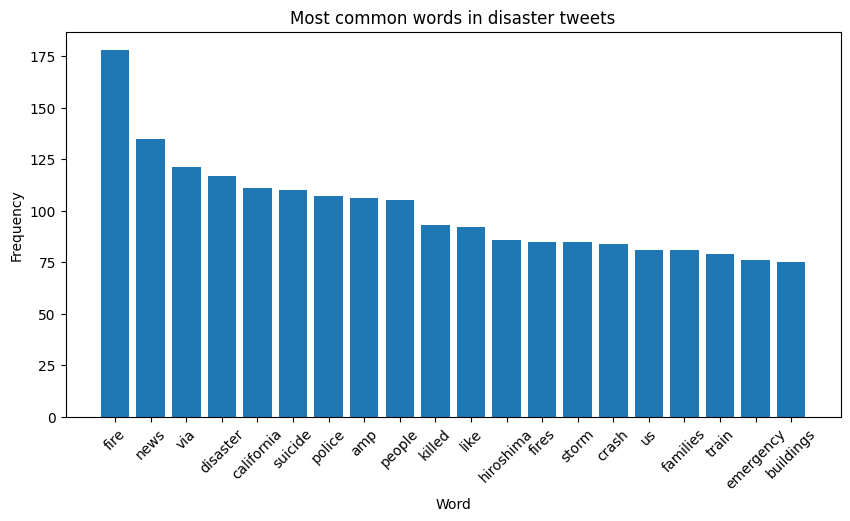

In [76]:
#plot the most common words in disaster tweets with a bar chart
disaster_word_freq_df = pd.DataFrame(disaster_word_freq.most_common(20), columns=['word', 'frequency'])
plt.figure(figsize=(10, 5))
plt.bar(disaster_word_freq_df['word'], disaster_word_freq_df['frequency'])
plt.xticks(rotation=45)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most common words in disaster tweets')

Text(0.5, 1.0, 'Most common words in non-disaster tweets')

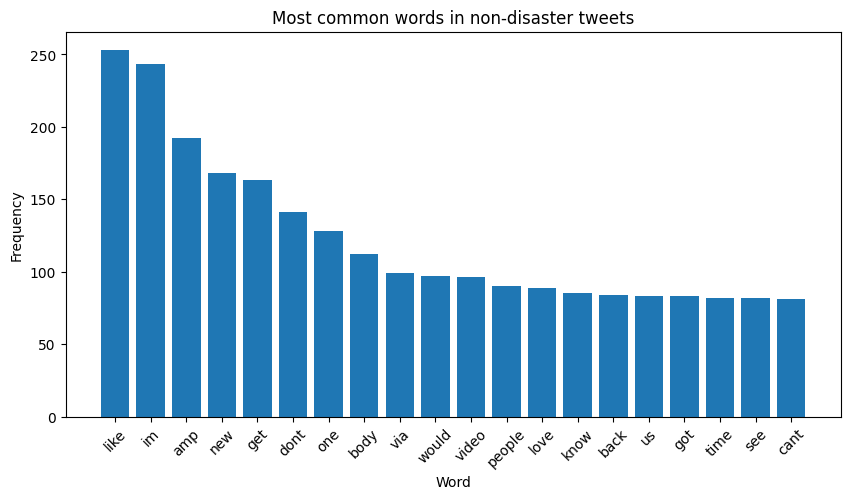

In [77]:
#plot the most common words in non-disaster tweets with a bar chart
non_disaster_word_freq_df = pd.DataFrame(non_disaster_word_freq.most_common(20), columns=['word', 'frequency'])
plt.figure(figsize=(10, 5))
plt.bar(non_disaster_word_freq_df['word'], non_disaster_word_freq_df['frequency'])
plt.xticks(rotation=45)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most common words in non-disaster tweets')

Palabras como Fire, News y Distaster son palabras que aparecen con mucha frecuencia en el conjunto de desastres, pero no en el conjunto de no desastres, por lo que pueden ser de mucha utilidad para la clasificación. Palabas como amp, aparecen de manera significativa en ambos conjuntos, lo cual puede empeorar el rendimiento del modelo, por lo que debe considerarse eliminarlas.

Los trigramas y bigramas pueden ser muy útiles, ya que palabras como "Fire" o "Disaster" son muy comúnmente utilizadas para expresar algo completamente distinto a un desastre y el contexto en el cual estas son utilizadas puede aportar mucha información para poder realizar la clasificación.

In [78]:
#find the common words in both disaster and non-disaster tweets
disaster_common_words = {word for word, _ in disaster_word_freq.most_common(20)}
non_disaster_common_words = {word for word, _ in non_disaster_word_freq.most_common(20)}

common_words = disaster_common_words.intersection(non_disaster_common_words)

common_words


{'amp', 'like', 'people', 'us', 'via'}

In [79]:
#delete the common words from de clean_text column
def remove_common_words(text):
    return ' '.join([word for word in text.split() if word not in common_words])

df['clean_text'] = df['clean_text'].apply(remove_common_words)

df[['text', 'clean_text']].head()

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",receive wildfires evacuation orders california
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...


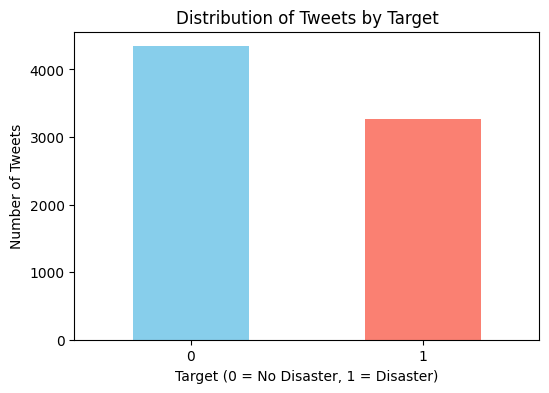

In [80]:
#Distribution of the target variable
target_distribution = df['target'].value_counts()

plt.figure(figsize=(6, 4))
target_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Tweets by Target')
plt.xlabel('Target (0 = No Disaster, 1 = Disaster)')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)
plt.show()


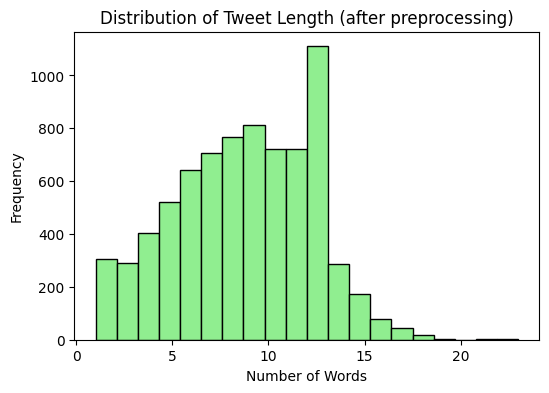

In [81]:
#Length of the tweets after preprocessing
df['tweet_length'] = df['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(6, 4))
df['tweet_length'].plot(kind='hist', bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution of Tweet Length (after preprocessing)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


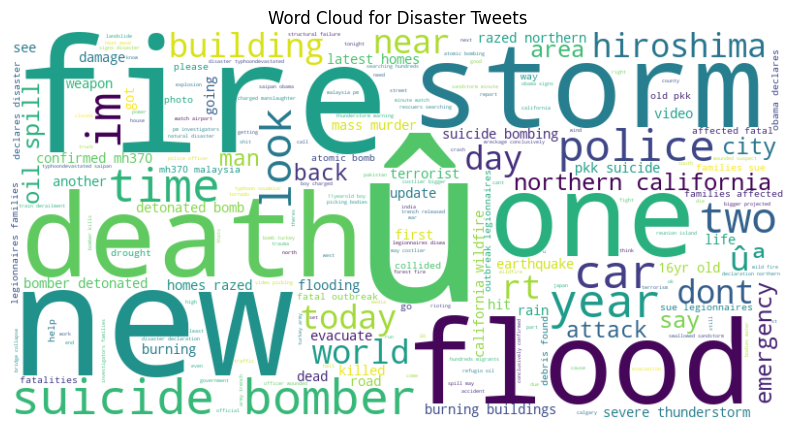

In [82]:
#Word cloud for disaster tweets
disaster_tweets = df[df['target'] == 1]['clean_text']
disaster_tweets = ' '.join(disaster_tweets)

""" words = disaster_tweets.split(" ")
most_common_words = Counter(words).most_common(10000)
print(most_common_words) """

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(disaster_tweets)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Disaster Tweets')
plt.show()

In [83]:
special_chars = ["\x89û", ""]

def remove_special_chars(text):
    for char in special_chars:
        text = text.replace(char, '')
    return text

df['clean_text'] = df['clean_text'].apply(remove_special_chars)